In [1]:
import innvestigate
import innvestigate.utils
import keras.applications.vgg16 as vgg16
import sys
import cv2

sys.argv.pop()
sys.argv.pop()

if len(sys.argv)==1:
    sys.argv.append('Liver') #image_type
    sys.argv.append('Sex') #target
    sys.argv.append('VGG16') #model_name
    sys.argv.append('Adam') #optimizer
    sys.argv.append('0.0001') #learning_rate
    sys.argv.append('0.0') #lam regularization: weight shrinking
    sys.argv.append('0.0') #dropout

#read parameters from command
image_type = sys.argv[1]
target = sys.argv[2]
model_name = sys.argv[3]
optimizer_name = sys.argv[4]
learning_rate = float(sys.argv[5])
lam = float(sys.argv[6])
dropout_rate = float(sys.argv[7])

#load libraries, import functions and import parameters (nested import in the line below)
from MI_helper_parameters import *

#set other parameters accordingly
image_size = input_size_models[model_name]
prediction_type = 'saliency'
#loss = dict_losses[target]
#metrics = dict_metrics[prediction_type]
#main_metric = main_metrics[target]
version = target + '_' + image_type + '_' + model_name + '_' + optimizer_name + '_' + str(learning_rate) + '_' + str(lam) + '_' + str(dropout_rate) + '_' + str(batch_size)
dir_images = dict_dir_images[image_type]

#load data features
DATA_FEATURES = {}
for fold in folds:
    DATA_FEATURES[fold] = pd.read_csv(path_store + 'data_features_' + image_type + '_' + target + '_' + fold + '.csv')

#generate the data generators
datagen_train = ImageDataGenerator(rescale=1./255., rotation_range=20, width_shift_range=0.2, height_shift_range=0.2)
datagen_test = ImageDataGenerator(rescale=1./255.)
class_mode_train = 'raw'
class_mode_test = None
GENERATORS = {}
STEP_SIZES = {}
for fold in folds:
    if fold == 'test':
        datagen = datagen_test
        class_mode = class_mode_test
    else:
        datagen = datagen_train
        class_mode = class_mode_train
    #
    # define data generator
    generator_fold = datagen.flow_from_dataframe(
        dataframe=DATA_FEATURES[fold],
        directory=dir_images,
        x_col='eid',
        y_col=target,
        color_mode='rgb',
        batch_size=batch_size,
        seed=0,
        shuffle=True,
        class_mode='raw',
        target_size=(image_size, image_size))
    #
    # assign variables to their names
    GENERATORS[fold] = generator_fold
    STEP_SIZES[fold] = generator_fold.n // generator_fold.batch_size


#define the model
x, base_model_input = generate_base_model(model_name=model_name, lam=lam, dropout_rate=dropout_rate, import_weights=import_weights)
model = complete_architecture(x=x, input_shape=base_model_input, activation=dict_activations[prediction_type], lam=lam, dropout_rate=dropout_rate)
#set_learning_rate(model=model, optimizer_name=optimizer_name, learning_rate=learning_rate, loss=dict_losses[prediction_type], metrics=[dict_metrics_functions[metric] for metric in dict_metrics[prediction_type]])

#load weights
path_weights = path_store + 'model_weights_' + version + '.h5'
model.load_weights(path_weights)


Using TensorFlow backend.
W1108 02:32:50.320913 140193788393280 deprecation_wrapper.py:119] From /n/groups/patel/Alan/Aging/Medical_Images/scripts/MI_helper_libraries.py:43: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



Found 30304 validated image filenames.
Found 3776 validated image filenames.


W1108 02:32:57.411299 140193788393280 deprecation_wrapper.py:119] From /home/al311/python_3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 02:32:57.414394 140193788393280 deprecation_wrapper.py:119] From /home/al311/python_3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 02:32:57.423784 140193788393280 deprecation_wrapper.py:119] From /home/al311/python_3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1108 02:32:57.458505 140193788393280 deprecation_wrapper.py:119] From /home/al311/python_3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.


Found 3776 validated image filenames.


W1108 02:32:57.970322 140193788393280 deprecation_wrapper.py:119] From /home/al311/python_3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1108 02:33:05.609538 140193788393280 deprecation.py:323] From /home/al311/python_3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3217: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


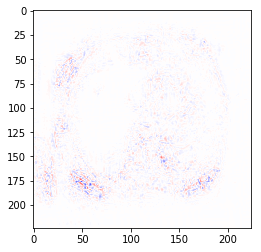

In [8]:
# Create analyzer
analyzer = innvestigate.create_analyzer("gradient", model)

batch_number = 0
image = GENERATORS['test'].__getitem__(batch_number)[0][:,:,:,:]

a = analyzer.analyze(image)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
cv2.imwrite(path_store + '../figures/test.jpg', a[0])

# Plot
plt.imshow(a[1], cmap="seismic", clim=(-1, 1))


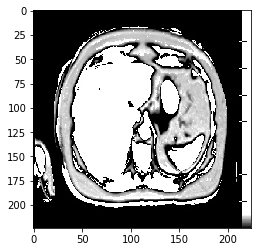

In [9]:
plt.imshow(image[1])


In [3]:
GENERATORS['test'].__getitem__(batch_number)[1]


array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [ ]:
young = 5, old = 16